# Capstone Project: City Clustering

#### Import packages

In [1]:
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import random
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import silhouette_score
import math

pd.options.display.float_format = '{:20,.4f}'.format   # prevents scientific notation

## Data Exploration

#### The used data set is taken from the demographic yearbook of the UN. Listed are cities with a population of 100,000 or more. Some countries like Canada and China are missing.

In [2]:
df_data_1 = pd.read_csv("file_path", sep = ";", encoding='latin-1', header = None)

In [3]:
df_data_1.columns = ["City", "Population"]
df_pop = df_data_1
df_pop.head()

,City,Population
0,6th of October City,802.306
1,A Coruña,245.053
2,Aachen,260.454
3,Abakan,166.666
4,Abbotabad,106.101


#### Give the Population column the right datatype int.

In [4]:
df_pop["Population"] = df_pop["Population"].str.replace(".", "").astype(int)
print(df_pop.dtypes)

City          object
Population     int32
dtype: object


In [5]:
df_pop.head()

,City,Population
0,6th of October City,802306
1,A Coruña,245053
2,Aachen,260454
3,Abakan,166666
4,Abbotabad,106101


#### Descriptive statistics of the dataset. We can see that there are 2838 cities in the dataset

In [6]:
df_pop.describe()

,Population
count,"2,838.0000"
mean,"403,374.2128"
std,"846,999.0529"
min,"100,002.0000"
25%,"131,130.7500"
50%,"193,644.0000"
75%,"353,144.0000"
max,"19,610,000.0000"


#### From the whole dataset we randomly choose 500 cities. For the whole dataset the amount of API calls needed would exceed the limited amount of calls we can make.

In [7]:
random.seed(42)
city_keys = random.sample(range(0, df_pop.shape[0]), k = 500)

In [8]:
df_red = df_pop.loc[city_keys].reset_index(drop = True)
df_red.head()

,City,Population
0,Torrejón de Ardoz,123213
1,Camacari,161226
2,Ampang/Ulu Kelang,120936
3,Jaleeb Al-Shuykh,219629
4,Himeji,536270


#### The statistics of the reduced set are quite similar to the statistics of the original set.

In [9]:
df_red.describe()

,Population
count,500.0000
mean,"389,931.6720"
std,"723,907.7932"
min,"100,064.0000"
25%,"130,172.5000"
50%,"199,243.5000"
75%,"375,928.7500"
max,"11,978,450.0000"


#### We use the OpenCage API to obtain the coordinates of the cities in our list.

In [10]:
key = "key"  # get api key from:  https://opencagedata.com

geocoder = OpenCageGeocode(key)

In [11]:
latitude = list(range(500))
longitude = list(range(500))

for i, city in enumerate(df_red["City"]):
    query = city  
    results = geocoder.geocode(query)
    try:                                                        # The API might fail to find a city
        latitude[i] = (results[0]['geometry']['lat'])
        longitude[i] = (results[0]['geometry']['lng'])
    except:
        latitude[i] = "nan"
        longitude[i] = "nan"

#### Find all the indices of cities where the API couldn't find coordinates.

In [12]:
fail_ind = [i for i in range(len(latitude)) if latitude[i] == "nan"]

In [13]:
fail_ind

[3, 26, 57, 77, 320, 438, 479]

In [14]:
df_red.loc[fail_ind]

,City,Population
3,Jaleeb Al-Shuykh,219629
26,Greshan (OR),105594
57,Shakkarpur,134883
77,Itabiraí,100300
320,Nala Sopara,184538
438,Krementchug,225454
479,Khayelitsa,314239


#### We manually change the names of the cities to the right ones that can be found by the API.

In [15]:
df_red.at[3, 'City'] = "Jleeb Al-Shuyoukh"
df_red.at[26, 'City'] = "Gresham"
df_red.at[57, 'City'] = "Shakarpur"
df_red.at[77, 'City'] = "Itaboraí"
df_red.at[320, 'City'] = "Nalasopara"
df_red.at[438, 'City'] = "Kremenchuk"
df_red.at[479, 'City'] = "Khayelitsha"

df_red.loc[fail_ind]

,City,Population
3,Jleeb Al-Shuyoukh,219629
26,Gresham,105594
57,Shakarpur,134883
77,Itaboraí,100300
320,Nalasopara,184538
438,Kremenchuk,225454
479,Khayelitsha,314239


#### Add the missing coordinates.

In [16]:
for i in fail_ind:
    query = df_red.at[i, 'City']   
    results = geocoder.geocode(query)
    
    latitude[i] = (results[0]['geometry']['lat'])
    longitude[i] = (results[0]['geometry']['lng'])

In [17]:
df_red["Latitude"] = latitude
df_red["Longitude"] = longitude

df_red.head()

,City,Population,Latitude,Longitude
0,Torrejón de Ardoz,123213,40.4588,-3.4793
1,Camacari,161226,-12.6998,-38.3261
2,Ampang/Ulu Kelang,120936,3.1867,101.7035
3,Jleeb Al-Shuyoukh,219629,29.2667,47.9333
4,Himeji,536270,34.8154,134.6855


#### Show all the chosen cities on a world map.

In [18]:
map_world = folium.Map(location=[0, 0], zoom_start=2)

# add markers to map
for lat, lng, city in zip(df_red['Latitude'], df_red['Longitude'], df_red['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  
map_world.save("map_world.png")    
map_world


#### Use the foursquare API to find the food venues in each city within a 1km radius (maximally 100 venues).

In [19]:
# @hidden_cell
CLIENT_ID = 'Id' # your Foursquare ID
CLIENT_SECRET = 'Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL, the categoryId is the food category ID
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
LIMIT = 100
city_venues = getNearbyVenues(names=df_red['City'],
                                   latitudes=df_red['Latitude'],
                                   longitudes=df_red['Longitude']
                                  )

Torrejón de Ardoz
Camacari
Ampang/Ulu Kelang
Jleeb Al-Shuyoukh
Himeji
Guarenas
Cleveland (OH)
Bukhara
WASHINGTON (DC)
San Cristóbal
Birigui
Soligorsk
Nantes
Aomori
Anju
Bordj el Kiffan
Grand Prairie (TX)
Haldwani-cum-Kathgodam
PYONGYANG
Sultanpur
Anand
Santo André
Fresno (CA)
Uberaba
San Cristóbal
Nalgonda
Gresham
Okara
Sohag
Jaunpur
Agra
Debre Zeit
Nara
Lalitpur
Jaú
DAMASCUS
Goiânia
LA PAZ
BUJUMBURA
Bonao
Marseille
Brasov
Lutsk
Latur
Surakarta
Irving (TX)
ATHINAI
Osorno
Saint-Paul (La Réunion)
Charlotte (NC)
Maringá
Bharatpur
San Pedro de Macoris
Kamensk-Uralsky
Thika
Tarsus
Macapá
Shakarpur
Fergana
Beawar
Aurora (IL)
Van
Gyumri (Leninakan)
Kajang dan Sungai Chua
Bhavnagar
Halisahar
Bryansk
Yakutsk
Yao
Opole
Tokushima
Magelang
Deoli
Malita
Louisville (KY)
Genova
Visalia (CA)
Itaboraí
Turhal
Belém
Tadepalligudem
Tokat
Douala
Saharanpur
Himamaylan
Derbent
Ovorhangay
Maroua
Ivanovo
Torun
Santa Cruz de Tenerife
Green Bay (WI)
Koronadal
Banda
Habra
Apalit
Kisumu
Mojokerto
Itaguaí
Batna
Gha

#### Save the table that we do not have to use the APIs every time we restart the kernel.

In [22]:
city_venues.to_pickle("city_venues.pkl")

In [23]:
city_venues = pd.read_pickle("city_venues.pkl")

In [24]:
city_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Torrejón de Ardoz,40.4588,-3.4793,El rincón de Rafa,40.4620,-3.4701,Tapas Restaurant
1,Torrejón de Ardoz,40.4588,-3.4793,The Irish Abbey,40.4518,-3.4734,Irish Pub
2,Torrejón de Ardoz,40.4588,-3.4793,Cafe Jool,40.4627,-3.4786,Breakfast Spot
3,Torrejón de Ardoz,40.4588,-3.4793,Cerveceria Restaurante Plaza Mayor,40.4584,-3.4792,Spanish Restaurant
4,Torrejón de Ardoz,40.4588,-3.4793,Buitre Bar,40.4534,-3.4733,Burger Joint


#### We want to cluster the cities based on how often certain types of food venues occur. We'd like to reduce the table and use only cities where we found at least 5 venues.

In [25]:
df_gr = city_venues.groupby('City').count()
u = df_gr[df_gr['Venue'] < 5]

for i in range(city_venues.shape[0]):
    if city_venues["City"][i] in u.index:
        city_venues.drop(i, inplace = True)

In [26]:
city_venues.groupby('City').count().head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
AMMAN,100,100,100,100,100,100
ASTANA,13,13,13,13,13,13
Aachen,100,100,100,100,100,100
Abiko,24,24,24,24,24,24
Abohar,7,7,7,7,7,7


#### Number of different venue categories.

In [27]:
len(set(city_venues["Venue Category"]))

202

#### We use one hot encoding on the venue category variable.

In [28]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# Insert the city column into the one hot encoded table
city_onehot.insert(0, "City", city_venues['City'], True) 

In [29]:
city_onehot.head()

,City,Acai House,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Ukrainian Restaurant,Unagi Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
0,Torrejón de Ardoz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Torrejón de Ardoz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Torrejón de Ardoz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Torrejón de Ardoz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Torrejón de Ardoz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Calculate the percentage of appearance of each type of food category per city.

In [30]:
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped.head()

,City,Acai House,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Ukrainian Restaurant,Unagi Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
0,AMMAN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0000
1,ASTANA,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2308,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,Aachen,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0100,0.0000,...,0.0000,0.0000,0.0000,0.0100,0.0000,0.0400,0.0000,0.0000,0.0000,0.0000
3,Abiko,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,Abohar,0.0000,0.0000,0.1429,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


#### Delete the "Restaurant" column because it is not specific enough.

In [31]:
city_grouped = city_grouped.drop(["Restaurant"], 1)

#### Give the most common venues per city.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AMMAN,Café,Middle Eastern Restaurant,Italian Restaurant,Burger Joint,Falafel Restaurant
1,ASTANA,Asian Restaurant,Fast Food Restaurant,Eastern European Restaurant,BBQ Joint,Turkish Restaurant
2,Aachen,Italian Restaurant,Bakery,German Restaurant,Café,Burger Joint
3,Abiko,Ramen Restaurant,Café,Japanese Restaurant,Pizza Place,Steakhouse
4,Abohar,Café,Cuban Restaurant,African Restaurant,Fast Food Restaurant,Indian Restaurant


## Clustering

#### We train the k-means clustering algorithm on the dataset for different amounts of clusters.

In [34]:
# set number of clusters
city_grouped_clustering = city_grouped.drop('City', 1)

max_k = 10     # maximum amount of clusters

classifiers_kmeans = []    # list of all the trained classifiers

for k in range(2,max_k + 1):     # Train for each amount of clusters between 2 and max_k
    kclusters = k

# run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
    classifiers_kmeans.append(kmeans)


#### To get an idea of how many clusters we should use we adopt the Silhouette Score.

In [35]:
# Metric evaluation
metric_k = np.zeros(max_k + 1)

for i in range(2, max_k + 1):
    metric_k[i] = silhouette_score(city_grouped_clustering, classifiers_kmeans[i-2].labels_ , metric = 'euclidean')

In [36]:
tabl = pd.DataFrame(columns = ["Clusters", "Score"])
tabl["Clusters"] = np.arange(2,max_k +1)
tabl["Score"] = metric_k[2:max_k +1]
tabl.set_index(["Clusters"], inplace = True)
tabl

,Score
Clusters,
2,0.1207
3,0.1366
4,0.1057
5,0.1194
6,0.1245
7,0.1259
8,0.1004
9,0.1089
10,0.0926


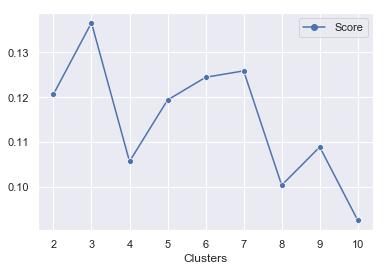

In [37]:
ax = sns.lineplot(data=tabl, markers=True)
plt.savefig('score.png')

#### The maximal score suggest only 3 clusters which might be a bit too small (underfitting). So we go for the next local maximum at 7 Clusters.

In [38]:
kclusters = 7

#### Add the class labels for each city.

In [39]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', classifiers_kmeans[kclusters -2].labels_)

city_merged = df_red

city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head()

,City,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Torrejón de Ardoz,123213,40.4588,-3.4793,1.0000,Café,Spanish Restaurant,Tapas Restaurant,Food,Mediterranean Restaurant
1,Camacari,161226,-12.6998,-38.3261,1.0000,Pizza Place,Brazilian Restaurant,Bakery,Café,Sandwich Place
2,Ampang/Ulu Kelang,120936,3.1867,101.7035,1.0000,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Burger Joint,Café
3,Jleeb Al-Shuyoukh,219629,29.2667,47.9333,0.0000,Fast Food Restaurant,American Restaurant,Pizza Place,Asian Restaurant,Café
4,Himeji,536270,34.8154,134.6855,2.0000,Japanese Restaurant,Café,Ramen Restaurant,Fast Food Restaurant,Italian Restaurant


#### Now we show the calculated clustering on the world map.

In [40]:
# create map
map_clusters = folium.Map(location=[0,0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if math.isnan(cluster) == True:
        continue # folium.CircleMarker(       # Use this line of code if cities with no (known) food venues should appear in gray
#            [lat, lon],
#            radius=5,
#            popup=label,
#            color='grey',
#            fill=True,
#            fill_color='grey',
#            fill_opacity=0.7).add_to(map_clusters)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=2,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
map_clusters.save("map_world_cluster.html")          
map_clusters

#### Add the cluster labels to the one hot encoded table

In [41]:
city_grouped.insert(0, 'Cluster Labels', classifiers_kmeans[kclusters -2 ].labels_)

city_merged_clusters = df_red.join(city_grouped.set_index('City'), on='City')

city_merged_clusters.head()

,City,Population,Latitude,Longitude,Cluster Labels,Acai House,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,...,Ukrainian Restaurant,Unagi Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
0,Torrejón de Ardoz,123213,40.4588,-3.4793,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,Camacari,161226,-12.6998,-38.3261,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,Ampang/Ulu Kelang,120936,3.1867,101.7035,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0282,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,Jleeb Al-Shuyoukh,219629,29.2667,47.9333,0.0000,0.0000,0.0000,0.0000,0.0000,0.1429,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,Himeji,536270,34.8154,134.6855,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250,0.0000


#### Show the percentage of appearance of a certain food venue for each cluster.

In [42]:
city_avg = city_merged_clusters.drop(['Population','Latitude', 'Longitude'], 1).groupby('Cluster Labels').mean().reset_index()
city_avg

,Cluster Labels,Acai House,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Ukrainian Restaurant,Unagi Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
0,0.0000,0.0000,0.0000,0.0214,0.0000,0.0147,0.0008,0.0000,0.0339,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0011,0.0000,0.0000
1,1.0000,0.0016,0.0001,0.0055,0.0003,0.0282,0.0004,0.0008,0.0210,0.0001,...,0.0001,0.0001,0.0000,0.0085,0.0001,0.0053,0.0001,0.0015,0.0000,0.0002
2,2.0000,0.0000,0.0000,0.0000,0.0000,0.0063,0.0000,0.0000,0.0039,0.0000,...,0.0000,0.0052,0.0000,0.0014,0.0000,0.0009,0.0047,0.0050,0.0099,0.0035
3,3.0000,0.0000,0.0075,0.0075,0.0000,0.0030,0.0005,0.0000,0.0169,0.0000,...,0.0016,0.0000,0.0005,0.0032,0.0000,0.0017,0.0000,0.0008,0.0000,0.0000
4,4.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0000,0.0000,0.0632,0.0054,...,0.0000,0.0000,0.0000,0.0419,0.0000,0.0000,0.0000,0.0061,0.0000,0.0000
5,5.0000,0.0013,0.0088,0.0105,0.0000,0.0015,0.0000,0.0000,0.0085,0.0000,...,0.0000,0.0000,0.0000,0.0017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,6.0000,0.0000,0.0000,0.0000,0.0000,0.0061,0.0000,0.0000,0.0103,0.0000,...,0.0000,0.0000,0.0009,0.0043,0.0000,0.0011,0.0000,0.0093,0.0000,0.0000


#### Find the n most common food categories in each cluster.

In [43]:
# n largest values
n = 10
cluster_tables = []
for i in range(kclusters):
    print("Cluster Label {}".format(i))
    tab = city_avg.drop(['Cluster Labels'],1).T[i].to_frame().nlargest(n, columns = [i])
    tab.index.name = "Categories"
    cluster_tables.append(tab)
    print(tab)
    print("\n")

Cluster Label 0
                                        0
Categories                               
Fast Food Restaurant               0.2597
Café                               0.0781
BBQ Joint                          0.0717
Pizza Place                        0.0666
Chinese Restaurant                 0.0342
Asian Restaurant                   0.0339
Burger Joint                       0.0296
Mexican Restaurant                 0.0263
Bakery                             0.0216
African Restaurant                 0.0214


Cluster Label 1
                                        1
Categories                               
Café                               0.0680
Pizza Place                        0.0533
Sandwich Place                     0.0441
Bakery                             0.0439
Italian Restaurant                 0.0415
Burger Joint                       0.0370
Fast Food Restaurant               0.0313
Mexican Restaurant                 0.0305
American Restaurant                0.0282


#### Make a list of the top 5 categories from each cluster

In [44]:
# Create table with most common appearances
top = 5
cats = []

for i in range(kclusters):
    cats = cats + list(city_avg.drop(['Cluster Labels'],1).T[i].to_frame().nlargest(top, columns = [i]).index)
    

In [45]:
list(set(cats))

['Italian Restaurant',
 'Pizza Place',
 'Snack Place',
 'Café',
 'Indian Restaurant',
 'BBQ Joint',
 'Japanese Restaurant',
 'Asian Restaurant',
 'Sandwich Place',
 'Ramen Restaurant',
 'Burger Joint',
 'Chinese Restaurant',
 'Bakery',
 'Fast Food Restaurant']

#### Show percentage of those categories for each cluster.

In [46]:
comp_tabl = pd.DataFrame()
comp_tabl["Categories"] = list(set(cats))
comp_tabl.set_index("Categories", inplace = True)

In [47]:
for i in range(kclusters):
    comp_tabl = comp_tabl.join(cluster_tables[i], on = "Categories")
comp_tabl

,0,1,2,3,4,5,6
Categories,,,,,,,
Italian Restaurant,nan,0.0415,0.0356,0.0381,nan,nan,0.0414
Pizza Place,0.0666,0.0533,nan,0.0451,0.0375,0.0796,0.2378
Snack Place,nan,nan,nan,nan,0.0772,0.0599,nan
Café,0.0781,0.0680,0.0829,0.3322,0.0574,0.0272,0.1489
Indian Restaurant,nan,nan,nan,nan,0.3215,0.0231,nan
BBQ Joint,0.0717,nan,0.0436,nan,nan,0.0308,nan
Japanese Restaurant,nan,nan,0.1361,nan,nan,nan,nan
Asian Restaurant,0.0339,nan,nan,0.0169,0.0632,nan,nan
Sandwich Place,nan,0.0441,nan,nan,0.0165,nan,nan


#### For simplicity we remove all rows with only one value (if the value is small)

In [48]:
for cat in comp_tabl.index:
    if len(list(set(comp_tabl.fillna(0).loc[cat]))) == 2 and max(comp_tabl.fillna(0).loc[cat]) < 0.05 :
        comp_tabl.drop(cat, inplace = True)

In [49]:
comp_tabl

,0,1,2,3,4,5,6
Categories,,,,,,,
Italian Restaurant,nan,0.0415,0.0356,0.0381,nan,nan,0.0414
Pizza Place,0.0666,0.0533,nan,0.0451,0.0375,0.0796,0.2378
Snack Place,nan,nan,nan,nan,0.0772,0.0599,nan
Café,0.0781,0.0680,0.0829,0.3322,0.0574,0.0272,0.1489
Indian Restaurant,nan,nan,nan,nan,0.3215,0.0231,nan
BBQ Joint,0.0717,nan,0.0436,nan,nan,0.0308,nan
Japanese Restaurant,nan,nan,0.1361,nan,nan,nan,nan
Asian Restaurant,0.0339,nan,nan,0.0169,0.0632,nan,nan
Sandwich Place,nan,0.0441,nan,nan,0.0165,nan,nan


#### Replace nan with 0.

In [50]:
# Make nan to 0
comp_tabl.fillna(0, inplace = True)
comp_tabl

,0,1,2,3,4,5,6
Categories,,,,,,,
Italian Restaurant,0.0000,0.0415,0.0356,0.0381,0.0000,0.0000,0.0414
Pizza Place,0.0666,0.0533,0.0000,0.0451,0.0375,0.0796,0.2378
Snack Place,0.0000,0.0000,0.0000,0.0000,0.0772,0.0599,0.0000
Café,0.0781,0.0680,0.0829,0.3322,0.0574,0.0272,0.1489
Indian Restaurant,0.0000,0.0000,0.0000,0.0000,0.3215,0.0231,0.0000
BBQ Joint,0.0717,0.0000,0.0436,0.0000,0.0000,0.0308,0.0000
Japanese Restaurant,0.0000,0.0000,0.1361,0.0000,0.0000,0.0000,0.0000
Asian Restaurant,0.0339,0.0000,0.0000,0.0169,0.0632,0.0000,0.0000
Sandwich Place,0.0000,0.0441,0.0000,0.0000,0.0165,0.0000,0.0000


#### Show the percentages of each food category in each cluster.

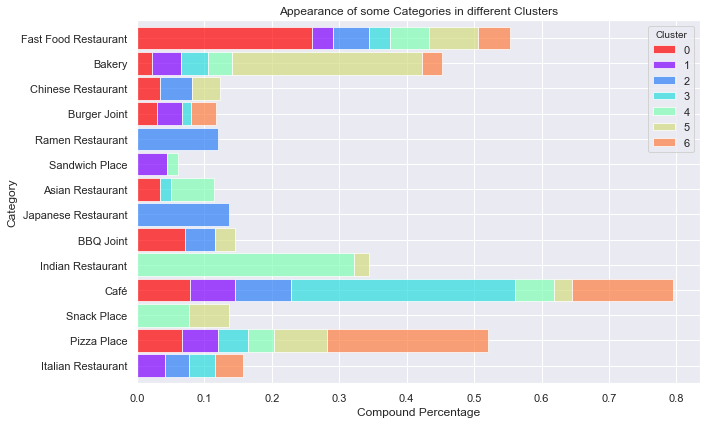

In [51]:
comp_tabl.plot(kind ='barh', 
          figsize=(10, 6),
          alpha=0.7,
          width = 0.9,  
          stacked = True,
          color = [rainbow[int(cluster)-1] for cluster in range(kclusters)]
         )

plt.title('Appearance of some Categories in different Clusters')
plt.ylabel('Category')
plt.xlabel('Compound Percentage')
plt.legend(title = "Cluster")
plt.tight_layout()
plt.savefig("bar.png")
plt.show()

## Prediction

#### Now we can predict the cluster label for arbitrary (big) cities. We prepare the data in the same way as before.

In [52]:
city_name = "New York"

In [53]:
# get coordinates 
query = city_name  
results = geocoder.geocode(query)
try:
    latitude = (results[0]['geometry']['lat'])
    longitude = (results[0]['geometry']['lng'])
    print(latitude, longitude)
except:
    print("No coordinates found")

40.7127281 -74.0060152


In [54]:
ven = getNearbyVenues([city_name], [latitude], [longitude], radius=1000)

New York


In [55]:
ven.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.7127,-74.0060,Augustine,40.7113,-74.0067,French Restaurant
1,New York,40.7127,-74.0060,Takahachi Bakery,40.7137,-74.0088,Bakery
2,New York,40.7127,-74.0060,Pisillo Italian Panini,40.7105,-74.0075,Sandwich Place
3,New York,40.7127,-74.0060,Joe’s Pizza,40.7103,-74.0077,Pizza Place
4,New York,40.7127,-74.0060,Aahar Indian Cuisine,40.7133,-74.0080,Indian Restaurant


In [56]:
ven_onehot = pd.get_dummies(ven[['Venue Category']], prefix="", prefix_sep="")

ven_onehot.insert(0, "City", ven['City'], True)

In [57]:
ven_grouped = ven_onehot.groupby('City').mean().reset_index()

In [58]:
ven_grouped.drop(["City"], axis =1, inplace = True)
if "Restaurant" in ven_grouped.columns:
    ven_grouped.drop(["Restaurant"], axis =1, inplace = True)
    
ven_grouped

,American Restaurant,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Breakfast Spot,Burger Joint,Burrito Place,Café,Chinese Restaurant,...,New American Restaurant,Pizza Place,Poke Place,Ramen Restaurant,Salad Place,Sandwich Place,Shanghai Restaurant,Steakhouse,Sushi Restaurant,Wings Joint
0,0.0400,0.0200,0.0100,0.0100,0.0500,0.0100,0.0400,0.0100,0.0600,0.0500,...,0.0200,0.0500,0.0100,0.0100,0.0200,0.0600,0.0100,0.0200,0.0300,0.0100


In [59]:
features = city_grouped.drop(['City', 'Cluster Labels'], 1).columns

#### In order for the prediction algorithm to work we need to have the same features as before. This means we have to add the not appearing food categories to the table and delete those that weren't in the training set. 

In [60]:
pred = pd.DataFrame(columns = features)
for venue in ven_grouped.columns:
    if venue in features:
        pred[venue] = ven_grouped[venue]
    else:
        print("Venue {} with probability {} not in features".format(venue, ven_grouped[venue][0]))

pred.fillna(0, inplace = True)        

#### Now we have the table (or vector) that we can use for prediction.

In [61]:
pred

,Acai House,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,...,Ukrainian Restaurant,Unagi Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
0,0,0,0,0,0.0400,0,0,0.0200,0.0100,0,...,0,0,0,0,0,0,0,0.0100,0,0


#### Predict the cluster.

In [62]:
pred_cluster = classifiers_kmeans[kclusters -2].predict(pred)
print("The predicted cluster is {}.".format(pred_cluster[0]))

The predicted cluster is 1.


#### We compare the class with the city we have chosen for prediction.

In [63]:
compare = cluster_tables[pred_cluster[0]]
compare = compare.join(pred.T)
compare.columns= ['Whole Class', city_name]
compare

,Whole Class,New York
Categories,,
Café,0.0680,0.0600
Pizza Place,0.0533,0.0500
Sandwich Place,0.0441,0.0600
Bakery,0.0439,0.0500
Italian Restaurant,0.0415,0.0900
Burger Joint,0.0370,0.0400
Fast Food Restaurant,0.0313,0.0200
Mexican Restaurant,0.0305,0.0100
American Restaurant,0.0282,0.0400


#### Add the differences in value to the table.

In [64]:
diff = compare["Whole Class"] - compare[city_name]
compare["Difference"] = diff
compare

,Whole Class,New York,Difference
Categories,,,
Café,0.0680,0.0600,0.0080
Pizza Place,0.0533,0.0500,0.0033
Sandwich Place,0.0441,0.0600,-0.0159
Bakery,0.0439,0.0500,-0.0061
Italian Restaurant,0.0415,0.0900,-0.0485
Burger Joint,0.0370,0.0400,-0.0030
Fast Food Restaurant,0.0313,0.0200,0.0113
Mexican Restaurant,0.0305,0.0100,0.0205
American Restaurant,0.0282,0.0400,-0.0118


#### Show these differences in a graphic. The green bar shows the most underrepresented category, the red bar the most overrepresented category.

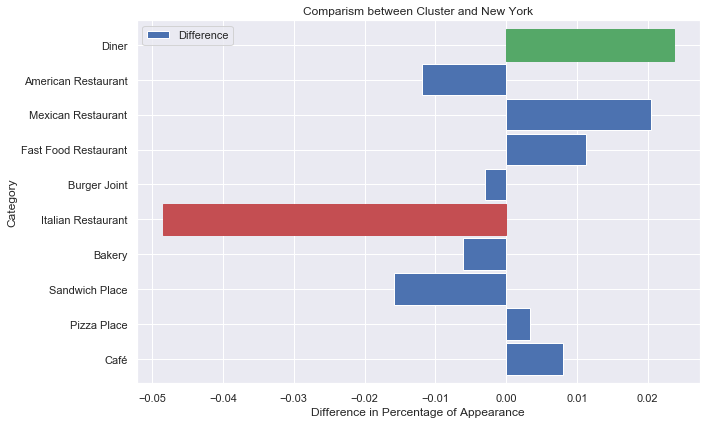

In [65]:
ax = compare.drop(["Whole Class", city_name], axis = 1).plot(kind ='barh', 
          figsize=(10, 6),
          alpha=1,
          width = 0.9,  
         )

ax.get_children()[compare["Difference"].values.argmax()].set_color('g') 
ax.get_children()[compare["Difference"].values.argmin()].set_color('r') 
plt.title('Comparism between Cluster and {}'.format(city_name))
plt.ylabel('Category')
plt.xlabel('Difference in Percentage of Appearance')
plt.tight_layout()
plt.savefig("mumb.png")
plt.show()